In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re

In [26]:
df = pd.read_csv("diabetic_data.csv")
print(f"Loaded shape: {df.shape}")

Loaded shape: (101766, 50)


## Basic Cleaning

In [28]:
# replace ? with NaN
df.replace("?", np.nan, inplace=True)

# Drop columns with very high missingness
df.drop(columns=["weight", "medical_specialty", "payer_code"], errors="ignore", inplace=True)

# Impute missing values
for col in df.columns:
    if df[col].isnull().any():
        if col.startswith("diag_"):
            df[col].fillna("UnknownDiag", inplace=True)
        else:
            # mode imputation for categoricals / leave numerics untouched (none in this dataset)
            mode_val = df[col].mode(dropna=True)
            df[col].fillna(mode_val.iloc[0] if not mode_val.empty else "Unknown", inplace=True)

In [29]:
# Binary target: 1 if readmitted in <30 days, else 0
df["readmitted_binary"] = (df["readmitted"] == "<30").astype(int)

In [30]:
def is_heart_dx(code: str) -> bool:
    """
    True if ICD‑9 diagnosis code is circulatory‑related
      • 390‑459 (Diseases of the circulatory system)
      • 785     (Cardiovascular symptoms)
    Skips E‑ and V‑codes.
    """
    if pd.isna(code):
        return False

    code = str(code).strip()
    if code.startswith(("E", "V")):
        return False

    m = re.match(r"^(\d{3})(?:\.\d+)?$", code)   # capture leading 3 digits
    if not m:
        return False

    num = int(m.group(1))
    return (390 <= num <= 459) or (num == 785)

# Apply to all three diagnosis columns
heart_mask = (
    df["diag_1"].apply(is_heart_dx) |
    df["diag_2"].apply(is_heart_dx) |
    df["diag_3"].apply(is_heart_dx)
)

df_heart = df[heart_mask].reset_index(drop=True)
print("After filter:", df_heart.shape)

After filter: (59313, 48)


*For every value in diag_1, diag_2, diag_3 we:* <br>
    • skip E‑ and V‑codes (external causes & supplemental factors). <br>
    • extract the first three digits of any numeric ICD‑9 code. <br>
    • mark it “heart‑related” if the code is 390 – 459 (diseases of the circulatory system) or 785 (cardiovascular symptoms). <br>
*Why?* <br>
Limits the analysis to visits whose primary or secondary diagnosis is plausibly “heart disease.”  This yields a clinically homogeneous cohort and prevents unrelated conditions from diluting model signals.

In [32]:
df_heart.to_csv("diabetic_heart_cleaned.csv", index=False)

## EDA

In [35]:
df1 = pd.read_csv("diabetic_heart_cleaned.csv")
print("Loaded cleaned data:", df1.shape)
print(df1.head())

Loaded cleaned data: (59313, 48)
   encounter_id  patient_nbr       race  gender      age  admission_type_id  \
0        500364     82442376  Caucasian    Male  [30-40)                  1   
1         35754     82637451  Caucasian    Male  [50-60)                  2   
2         55842     84259809  Caucasian    Male  [60-70)                  3   
3         63768    114882984  Caucasian    Male  [70-80)                  1   
4         12522     48330783  Caucasian  Female  [80-90)                  2   

   discharge_disposition_id  admission_source_id  time_in_hospital  \
0                         1                    7                 2   
1                         1                    2                 3   
2                         1                    2                 4   
3                         1                    7                 5   
4                         1                    4                13   

   num_lab_procedures  ...  insulin  glyburide-metformin  glipizide-met

### Missing Value Profile

In [36]:
missing_df1 = (df1.isna().mean() * 100).round(2).sort_values(ascending=False)
print("\nPercent missing per column:\n", missing_df)


Percent missing per column:
 encounter_id                0.0
patient_nbr                 0.0
acetohexamide               0.0
glipizide                   0.0
glyburide                   0.0
tolbutamide                 0.0
pioglitazone                0.0
rosiglitazone               0.0
acarbose                    0.0
miglitol                    0.0
troglitazone                0.0
tolazamide                  0.0
examide                     0.0
citoglipton                 0.0
insulin                     0.0
glyburide-metformin         0.0
glipizide-metformin         0.0
glimepiride-pioglitazone    0.0
metformin-rosiglitazone     0.0
metformin-pioglitazone      0.0
change                      0.0
diabetesMed                 0.0
readmitted                  0.0
glimepiride                 0.0
chlorpropamide              0.0
nateglinide                 0.0
num_medications             0.0
race                        0.0
gender                      0.0
age                         0.0
admission_

Highlights residual gaps after cleaning.  Helps decide if further imputation is needed before modelling.

### Numeric Summary

In [37]:
numeric_cols = [
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses",
]
print("\nNumeric summary:")
print(df1[numeric_cols].describe().T)


Numeric summary:
                      count       mean        std  min   25%   50%   75%  \
time_in_hospital    59313.0   4.295804   2.975750  1.0   2.0   4.0   6.0   
num_lab_procedures  59313.0  42.913240  19.490934  1.0  32.0  44.0  56.0   
num_procedures      59313.0   1.532413   1.881191  0.0   0.0   1.0   3.0   
num_medications     59313.0  16.577698   8.503247  1.0  11.0  15.0  20.0   
number_outpatient   59313.0   0.365164   1.281298  0.0   0.0   0.0   0.0   
number_emergency    59313.0   0.163573   0.739063  0.0   0.0   0.0   0.0   
number_inpatient    59313.0   0.620033   1.187702  0.0   0.0   0.0   1.0   
number_diagnoses    59313.0   7.514036   1.832268  2.0   6.0   8.0   9.0   

                      max  
time_in_hospital     14.0  
num_lab_procedures  132.0  
num_procedures        6.0  
num_medications      81.0  
number_outpatient    42.0  
number_emergency     63.0  
number_inpatient     18.0  
number_diagnoses     16.0  


    •Complete rows: All numeric features have 59,313 valid values (no remaining NaNs after cleaning).
	•Skew & outliers: Utilisation variables (num_lab_procedures, num_medications, _outpatient/ED/inpatient) are right‑skewed with heavy tails.
	•Low‑variance features: number_outpatient, number_emergency, number_inpatient have low variance.

### Histogram for Numeric Variables

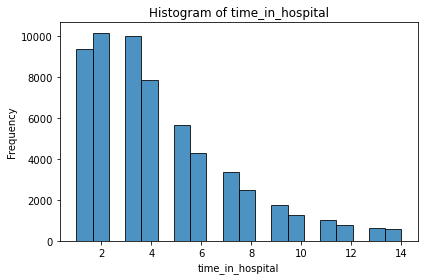

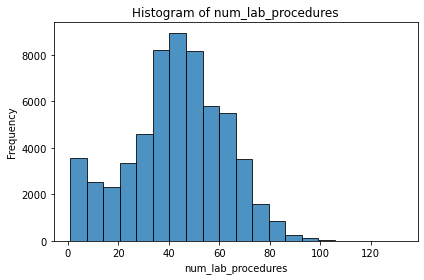

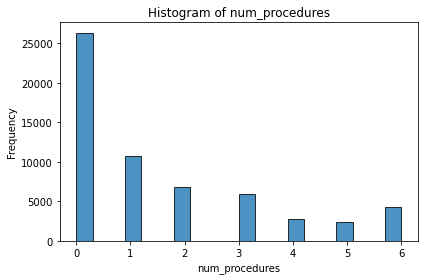

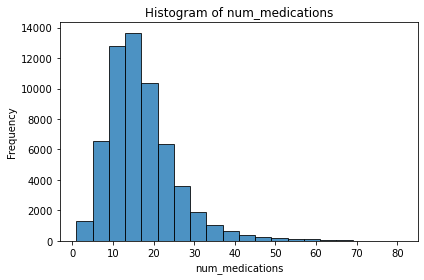

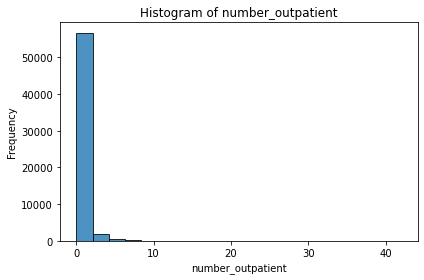

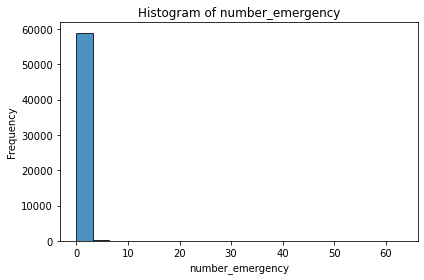

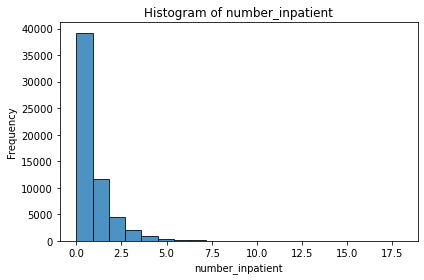

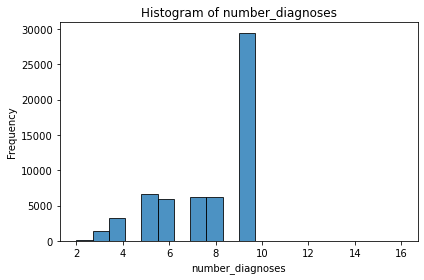

In [38]:
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    plt.hist(df1[col], bins=20, alpha=0.8, edgecolor="black")
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

| Feature | Distribution shape & key points | Practical implication |
|---------|---------------------------------|-----------------------|
| **`time_in_hospital`** | Right‑skew; mode ≈ 3 days; 75 % ≤ 6 days; tail to 14 days. | Most stays are short. Consider capping or binning long‑stay outliers. |
| **`num_lab_procedures`** | Near‑normal, centred ≈ 45 tests; mild right tail > 80. | Usable as continuous; extreme values (> 100) may be clipped. |
| **`num_procedures`** | Heavy spike at 0, geometric decline to 6. | Treat as categorical (0 / 1 / ≥ 2) rather than continuous. |
| **`num_medications`** | Right‑skew; peak ≈ 15 meds; tail to > 60. | Log‑transform or quantile‑bin to stabilise effects; high counts flag complex cases. |
| **`number_outpatient`** | 0‑inflated; rare values up to 42. | A binary “had outpatient visit” indicator captures most signal. |
| **`number_emergency`** | Almost all zeros; occasional 1–5; outliers ≤ 63. | Use indicator “≥ 1 ED visits”; raw count adds little. |
| **`number_inpatient`** | 0‑inflated; small tail to 18. | Bucket into 0 / 1 / ≥ 2 prior admissions. |
| **`number_diagnoses`** | Narrow peak at 9‑10; range 2–16 (ICD‑9 cap). | Keep as integer or bucket into low (≤ 6), mid (7‑9), high (≥ 10) co‑morbidity. |


### Bar Charts for Key Categorical Variables

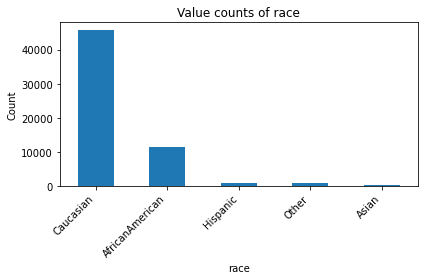

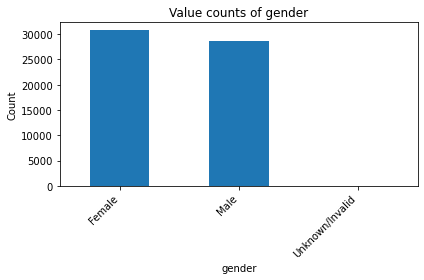

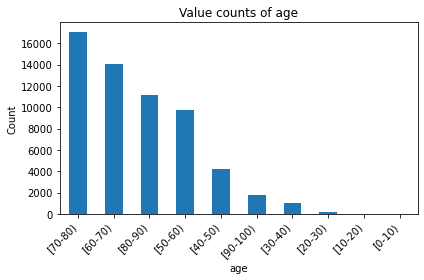

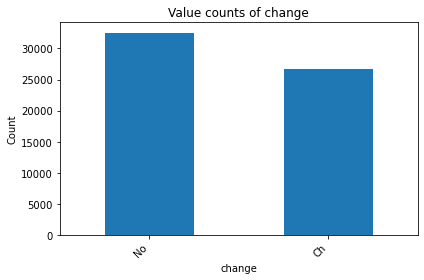

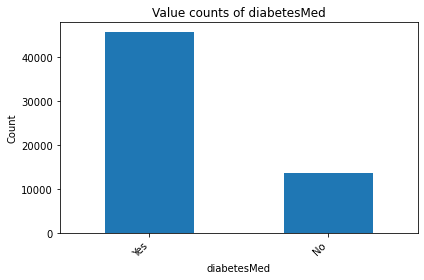

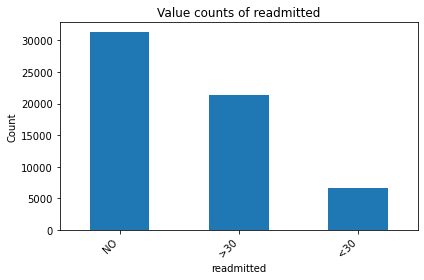

In [39]:
cat_cols = ["race", "gender", "age", "change", "diabetesMed", "readmitted"]
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    df1[col].value_counts(dropna=False).plot(kind="bar")
    plt.title(f"Value counts of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

| Variable | Dominant categories (counts) | What it tells us / modelling note |
|----------|------------------------------|-----------------------------------|
| **Race** | • *Caucasian* ≈ 44 k (75 %)<br> • *African‑American* ≈ 11 k (19 %)<br> • Others (Hispanic, Asian, Other) each < 3 % | Heavy class imbalance; rare groups may be merged into “Other” or given class weights to avoid high‑variance coefficients. |
| **Gender** | • Female ≈ 30 k (≈ 52 %)<br> • Male   ≈ 28 k (≈ 48 %)<br> • Unknown/Invalid &lt; 0.1 % | Nearly balanced → no need for re‑weighting; unknown values can be dropped or grouped as “Unknown.” |
| **Age** | Bucket counts drop steadily from `[70–80)` > `[60–70)` > `[50–60)`; < 4 % of patients are under 40. | Cohort is skewed older (heart‑disease expected). Treat age as ordered categories; younger bins may be merged to reduce sparsity. |
| **Change** (dosage change flag) | • No ≈ 32 k (55 %)<br> • Ch ≈ 26 k (45 %) | Reasonably balanced; keep as binary 0/1. |
| **DiabetesMed** | • Yes ≈ 44 k (74 %)<br> • No ≈ 15 k (26 %) | Most cardiac patients are on diabetes medication—consistent with comorbidity.  Variable may signal metabolic control. |
| **Readmitted** | • NO ≈ 31 k (52 %)<br> • \< 30 ≈ 22 k (37 %) – **target‑positive**<br> • \> 30 ≈ 6 k (11 %) | Positive class (<30 d) is sizeable but still minority (≈ 1 : 1.4).  Use stratified split; consider AUC/PR metrics rather than accuracy alone. |

### Readmission Rate (<30 days) by Selected Factors

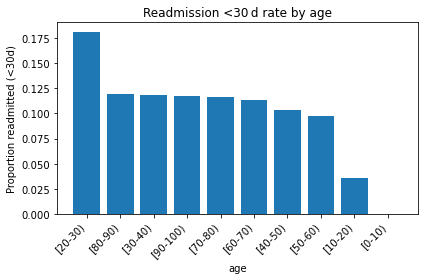

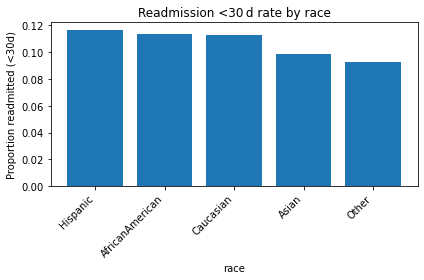

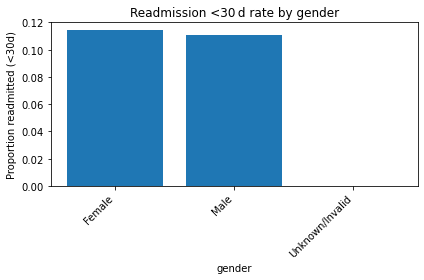

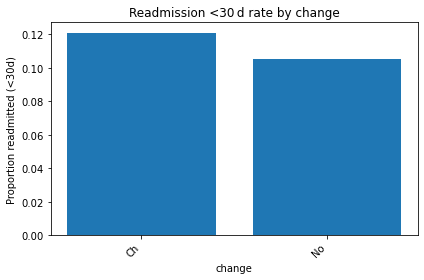

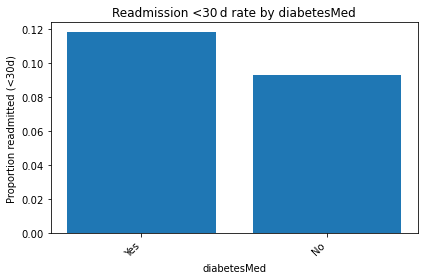

In [40]:
if "readmitted_binary" not in df1.columns:
    # create binary target
    df1["readmitted_binary"] = (df1["readmitted"] == "<30").astype(int)

def plot_rate(feature):
    rates = (
        df1.groupby(feature)["readmitted_binary"]
        .mean()
        .sort_values(ascending=False)
    )
    plt.figure(figsize=(6, 4))
    plt.bar(rates.index.astype(str), rates.values)
    plt.title(f"Readmission <30 d rate by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Proportion readmitted (<30d)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

for feat in ["age", "race", "gender", "change", "diabetesMed"]:
    plot_rate(feat)


| Factor | Highest‑risk category (≈ proportion) | Lowest‑risk category (≈ proportion) | Pattern & takeaway |
|--------|--------------------------------------|--------------------------------------|--------------------|
| **Age** | `[20–30)` ≈ 18 % | `[80–90)` ≈ 10 % ; `[90–100)` ≈ 4 % | Younger cardiac patients readmit most often, rates fall steadily with age (possible survivorship bias or different care pathways).  Age buckets carry a clear monotonic trend—keep ordered encoding. |
| **Race** | *Hispanic, African‑American, Caucasian* all ≈ 11 – 12 % | *Asian* ≈ 10 %; *Other* ≈ 9 % | Small but consistent race gradient.  Combine rare groups or use class weights; race still adds signal. |
| **Gender** | *Female* ≈ 11 % | *Male* ≈ 11 % (marginally lower) | Practically equal; gender may not be a strong predictor once other variables are included. |
| **Medication dosage change (`change`)** | *Yes (Ch)* ≈ 12 % | *No* ≈ 11 % | Any medication dose change during stay is associated with higher readmission—useful binary flag. |
| **Active diabetes medication (`diabetesMed`)** | *Yes* ≈ 12 % | *No* ≈ 10 % | Patients on diabetes drugs have greater readmission risk—likely more complex co‑morbid profile; keep as predictor. |

**Modelling implications**

* Age bucket and `change` / `diabetesMed` status show the clearest lift—expect meaningful coefficients.  
* Race effects are modest but could interact with socio‑economic variables if added.  
* Gender adds minimal incremental value; consider dropping if feature count needs trimming.

### Correlation Heat-Map among Numeric Variables

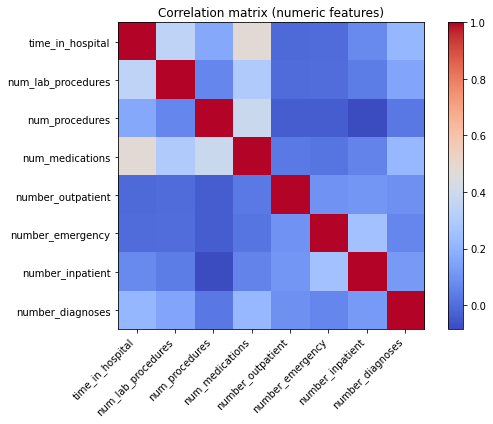

In [41]:
corr = df1[numeric_cols].corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha="right")
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation matrix (numeric features)")
plt.tight_layout()
plt.show()

| Relationship | ρ (approx.) | Interpretation |
|--------------|-------------|----------------|
| `time_in_hospital` ↔ `num_medications` | **0.45** | Longer stays naturally involve more prescription events – a sensible, moderate linkage. |
| `time_in_hospital` ↔ `num_lab_procedures` | ~ 0.30 | More inpatient days ⇒ more lab draws; still far from multicollinearity. |
| `num_medications` ↔ `num_lab_procedures` | ~ 0.30 | High‑utilisation encounters consume both meds and labs. |
| `number_inpatient` ↔ `number_emergency` | ~ 0.20 | Patients with prior admissions also register more ED visits – indicator of chronic instability. |
| Other pairs | < 0.20 or near 0 | Most utilisation variables are weakly related – useful independent signals. |

**Key take‑aways**

* **No strong collinearity** (|ρ| < 0.7 for every pair), so we can retain all numeric features in logistic regression without severe variance inflation.  
* Moderate positive cluster (`time_in_hospital`, `num_medications`, `num_lab_procedures`) captures overall resource intensity – may load on the same principal component if we later do dimensionality reduction.  
* Zero‑inflated count features (`number_outpatient`, `number_emergency`, `number_inpatient`) are largely independent of each other, supporting their inclusion as separate predictors.  
